In [83]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import numpy.ma as ma
import scipy.stats

from hist import Hist

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

## Shear map from a movable Single Isothermal Sphere.

In [138]:
xvalues = np.arange(0, 200., 4)
yvalues = np.arange(0, 200., 4)
xx, yy = np.meshgrid(xvalues, yvalues)

# Location of sphere
center = (100.00001, 100.00001)

Calculate the shear field from a singlular isothermal sphere with lensing potential

$$ \Psi = c\sqrt{x^2 + y^2} $$

with 

$$ \kappa = \frac{c}{2R} , \qquad \gamma_1 = c \frac{(y^2 - x^2)}{2R^3}, \qquad \gamma_2 = -\frac{cxy}{R^3} $$

where $ R = \sqrt{x^2 + y^2}$

In [139]:
c = .01

x = xx - center[0]
y = yy - center[1]

R = np.sqrt(x**2 + y**2)
kappa = c/(2*R)
gamma1 = c*(y**2 - x**2)/(2*R**3)
gamma2 = -c*(x*y)/R**3

g1 = gamma1/(1 - kappa)
g2 = gamma2/(1 - kappa)

# kill singularity at center of sphere for plotting
max_x, max_y = np.unravel_index(np.argmax(g2), g2.shape)
g2[max_x, max_y] = 0

# Calculate reduced shear
reduced_shear = g1 + g2*1j
magnitude = np.abs(reduced_shear)
phi = np.angle(reduced_shear)/2

## Explore the distribution of g1 and g2

In [140]:
# Make profile histogram

h = Hist.new.Reg(50, -.0003, .0003).Mean()
h.fill(g1.flatten(), sample=g2.flatten())

centers = h.axes.centers[0]
mean = h.view().value

with np.errstate(divide='ignore'):
    error_on_mean = np.sqrt(h.view().variance/h.view().count) 
    
mean_masked = ma.masked_where(h.view().count <= 2, mean)
#plt.errorbar(x=centers, y=mean_masked, yerr=error_on_mean, fmt = '.', markersize=3, elinewidth=.7)

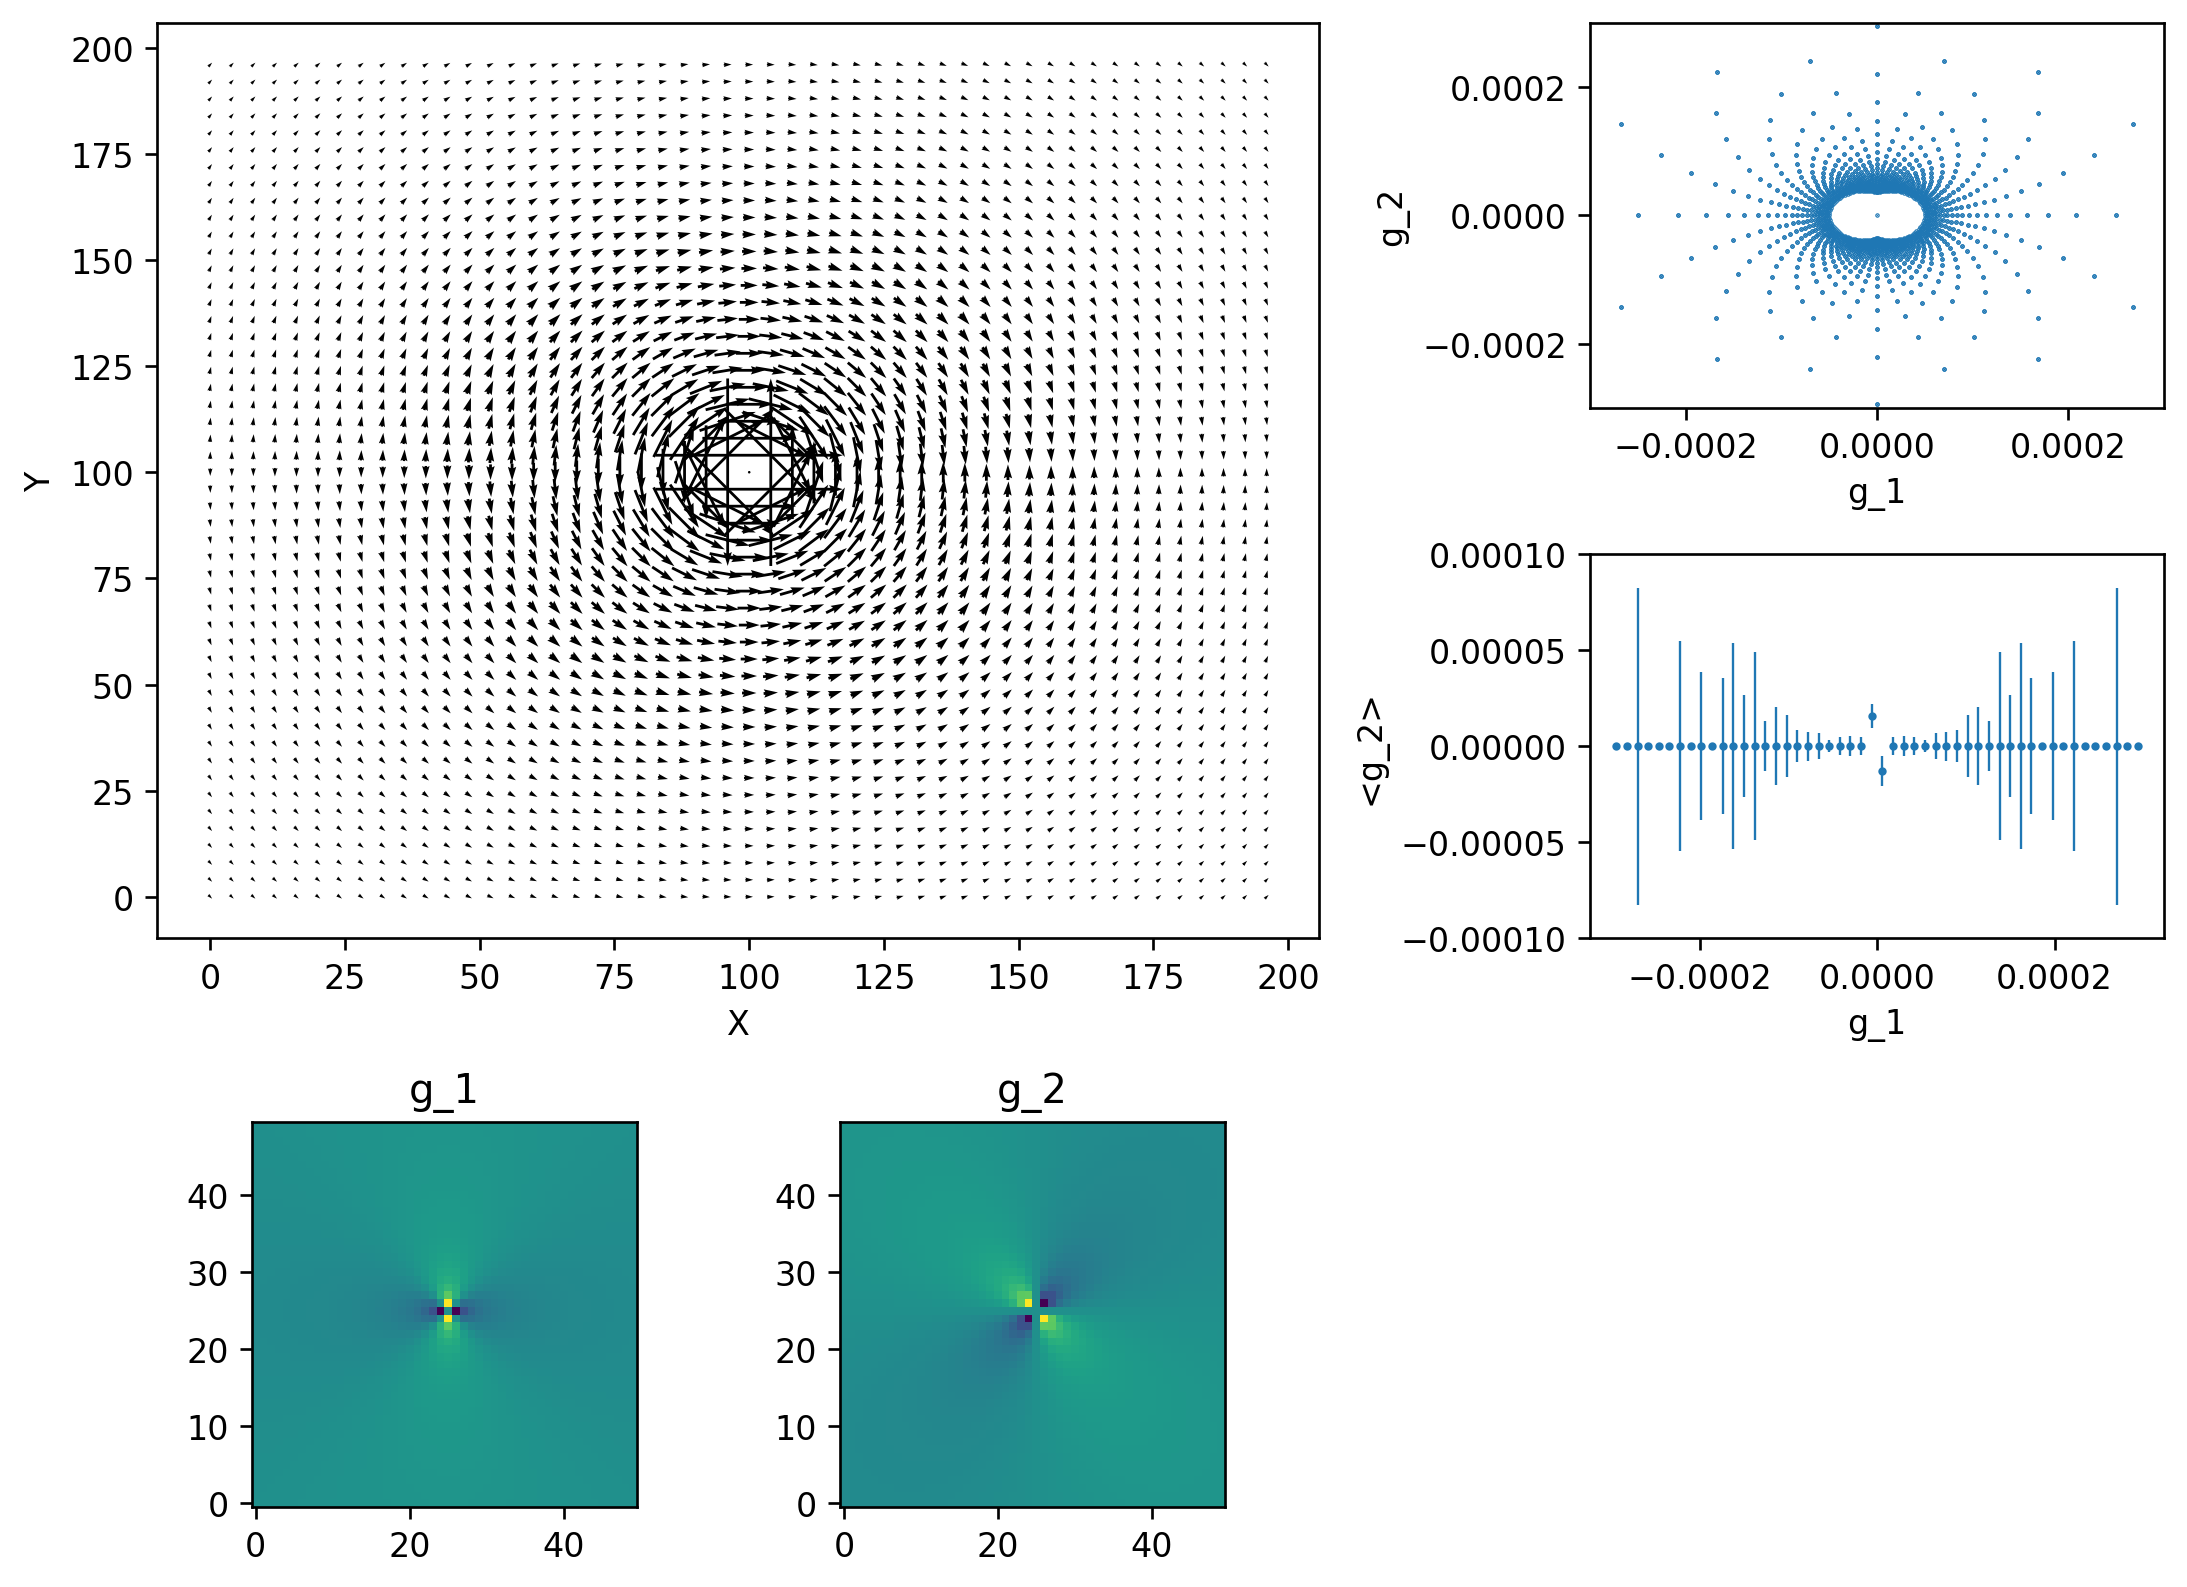

In [141]:
# Make the plots

# Canvas Setup
fig = plt.figure(figsize=(9, 6.5), constrained_layout=True)
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[0:2, 0:2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1,2])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])

# Plots
ax0.quiver(xx, yy, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid')
ax0.set_xlabel('X')
ax0.set_ylabel('Y')

ax1.scatter(g1, g2, marker='.', s=.5)
ax1.set_xlabel('g_1')
ax1.set_ylabel('g_2')
ax1.set_xlim(-.0003, .0003)
ax1.set_ylim(-.0003, .0003)

ax2.errorbar(x=centers, y=mean, yerr=error_on_mean, fmt = '.', markersize=3, elinewidth=.7)
ax2.set_xlabel('g_1')
ax2.set_ylabel('<g_2>')
ax2.set_ylim(-.0001, .0001)

ax3.imshow(g1, origin='lower')
ax4.imshow(g2, origin='lower')
ax3.set_title('g_1');
ax4.set_title('g_2');

Text(0, 0.5, 'Y')

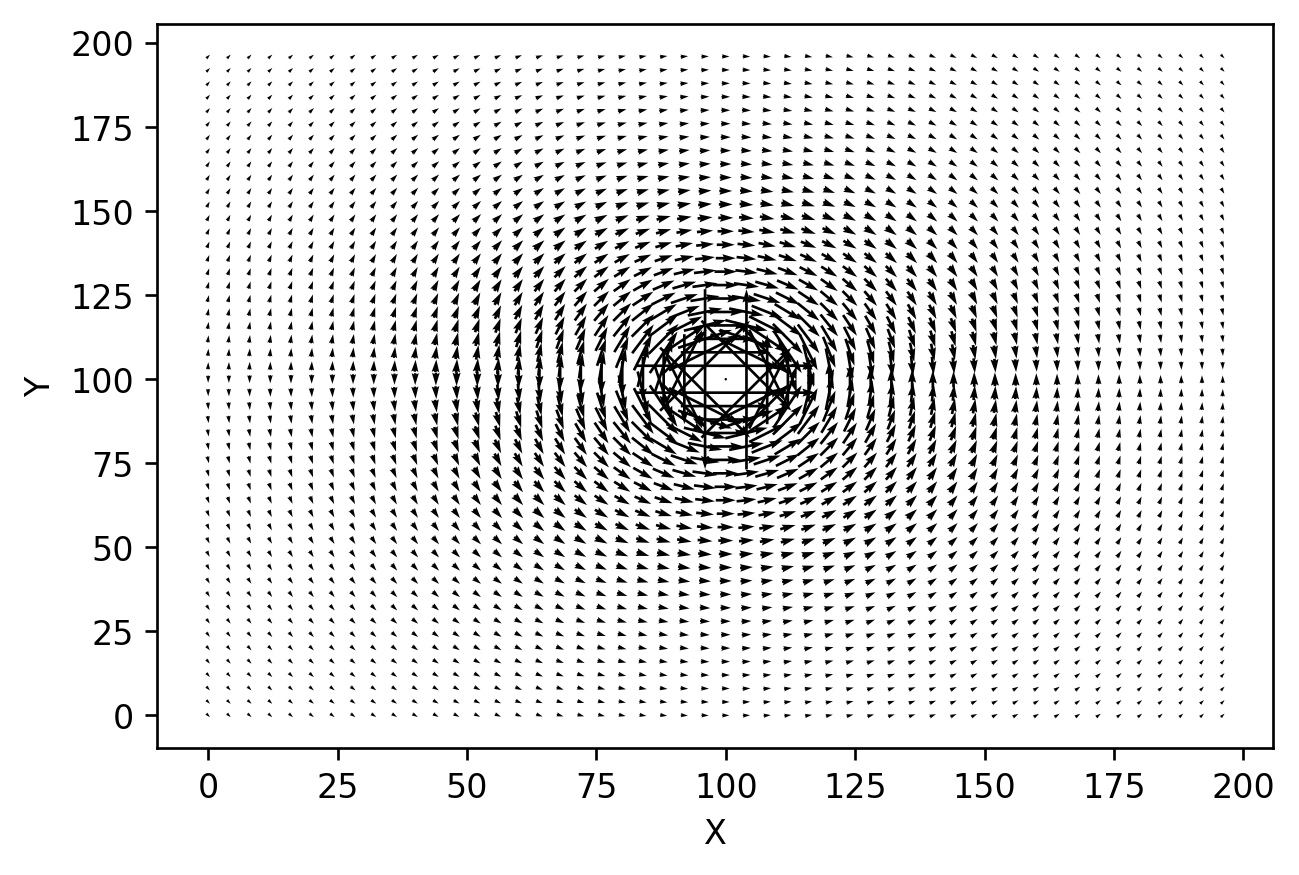

In [142]:
plt.quiver(xx, yy, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid')
plt.xlabel('X')
plt.ylabel('Y')

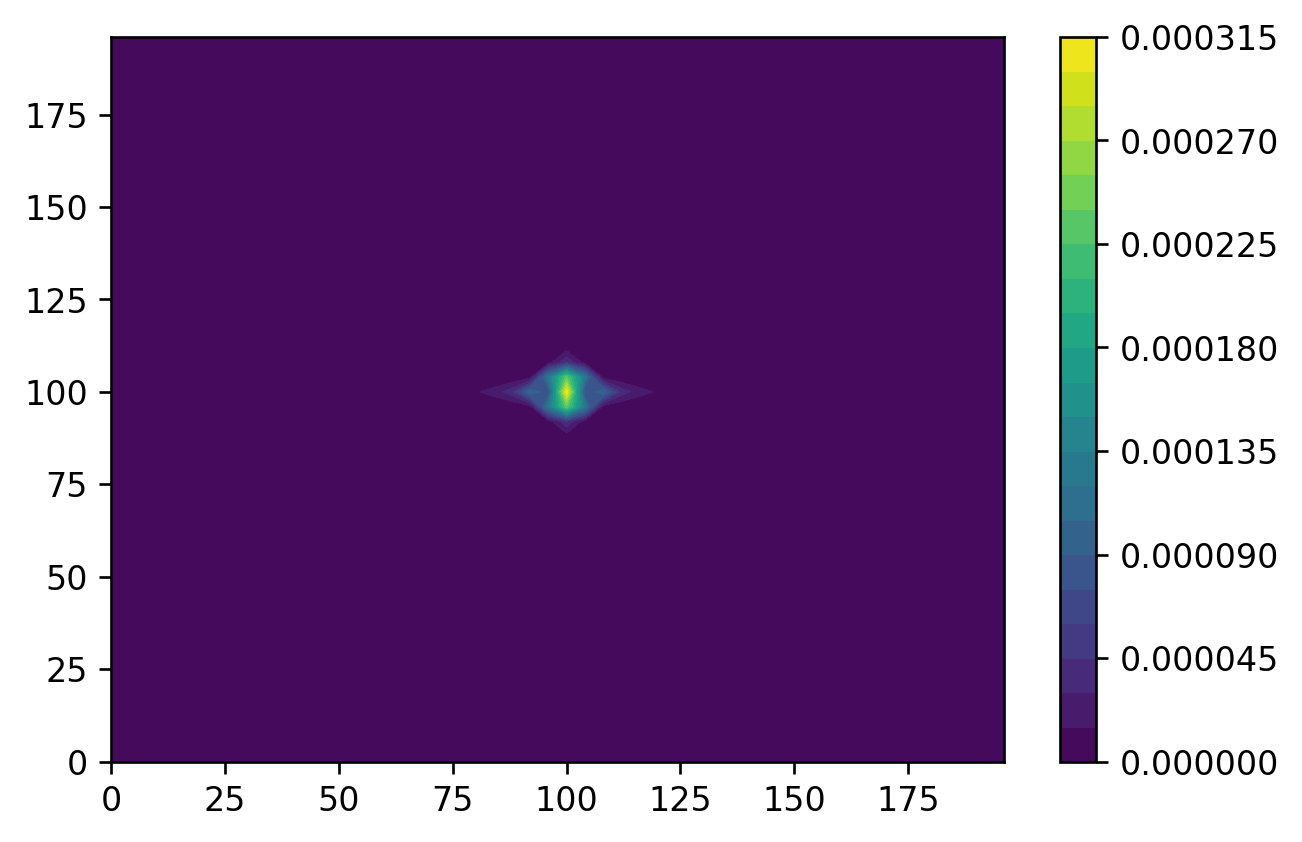

In [143]:
def calculate_curl(u, v,spacing_x, spacing_y):
    dFy_dx = np.gradient(v, spacing_x, axis=[1])
    dFx_dy = np.gradient(u, spacing_y, axis=[0])
    
    curl = dFy_dx - dFx_dy
    return curl

spacing_x = xvalues[1] - xvalues[0]
spacing_y = yvalues[1] - yvalues[0]

curl = calculate_curl(magnitude*np.cos(phi), magnitude*np.sin(phi), spacing_x, spacing_y)
plt.contourf(xvalues, yvalues, abs(curl), levels=20)
plt.colorbar()

In [ ]:
selected = df

g1 = selected.g1.to_dask_array(lengths=True)
g2 = selected.g2.to_dask_array(lengths=True)
e1 = selected.e1.to_dask_array(lengths=True)
e2 = selected.e2.to_dask_array(lengths=True)

bins = np.linspace(-.03,.03, 50)
bin_centers = (bins[:-1] + bins[1:])/2.
bin_number = da.digitize(g1, bins)

shear = da.stack([1-g1, -g2, -g2, 1+g1]).T.reshape(g1.size, 2, 2)
true  = da.array([e1, e2]).T
measured = np.einsum('kij,kj->ki', shear, true)[:,0]

diff = measured - g1

count = [(bin_number == i).sum() for i in range(1, len(bins))]
mean = [diff[bin_number == i].mean() for i in range(1, len(bins))]
mean2 = [(diff[bin_number == i]*diff[bin_number == i]).mean() for i in range(1, len(bins))]

count, mean, mean2 = dask.compute(count, mean, mean2)

count = np.array(count)
mean =  np.array(mean)
mean2 = np.array(mean2)
error = np.sqrt(mean2 - mean**2)/np.sqrt(count)